## Monitoring Nitrogen Dioxide using Sentinel-5P over Wuhan, China

## Table of Contents
* [Introduction](#1)
* [Necessary imports](#2)
* [Connect to your GIS](#3)
* [Get the data for analysis](#4)
    * [Download NO2 product](#5)
    * [Extract data from NetCDF](#6)
    * [Publish extracted rasters](#7)
    * [Access the published data for analysis](#8)
* [Methodology](#9) 
* [Preprocessing of the data](#10)
    * [Filter out the noise](#11)
* [Extract good quality NO2 pixels](#13)
* [Estimating the missing values](#14)
    * [Extract point data](#15)
    * [Interpolating the missing values](#16)
* [Visualize NO2 rasters](#18)
* [Conclusion](#19)
* [Data resources](#20)

## Introduction<a class="anchor" id="1"></a>

Nitrogen oxides(NOx) is group of highly reactive gases, Nirogen Dioxide (NO2) is a major trace gases of the group. The main source of NO2 emission in the atmosphere is fossil fuel burning, it can be through power plants, vehicles, etc. Acid rain is a resultant of NO2 interaction with water, oxygen in the atmosphere. High amount of NO2 causes smog and nutrient pollution in coastal water. 

China is one of the major contributer of NO2 emission in atmosphere due to urbanization, industrial and economic growth.Wuhan is the capital of Hubei province and most populous city of Central China. An epidemic of Coronavirus developed in Wuhan in December of 2019 which spread worldwide and became COVID-19 pandemic. Wuhan was locked down for approximatley three months to stop the spreading of the virus. The lockdown resulted in the decline of not only COVID cases but also the atmospheric NO2 concentration of the region.

As satellite remote sensing data is able to cover both the spatial distribution and temporal variation of atmospheric gases, it is widely accepted over the traditional atmosphere monitoring techniques.[The Sentinel-5 Precursor](https://sentinel.esa.int/web/sentinel/missions/sentinel-5p) is ESA's first Copernicus mission exclusively for atmospheric monitoring. The mission has one satellite containing TROPOspheric Monitoring Instrument (TROPOMI). 

[NO2 data product](https://sentinel.esa.int/documents/247904/2474726/Sentinel-5P-Level-2-Product-User-Manual-Nitrogen-Dioxide) is used in the current study to study the changes in the NO2 concentration due to COVID-19 lockdown.   

## Necessary imports<a class="anchor" id="2"></a>

In [1]:
import arcgis
import arcpy
import os, datetime
from datetime import datetime
from arcgis.gis import GIS
import arcgis.raster.functions
from arcgis.raster.functions import less_than, threshold, is_null, con
from arcgis.raster import analytics
from arcpy.sa import RescaleByFunction
from arcgis.geoanalytics.manage_data import calculate_fields
from arcgis.raster.analytics import convert_raster_to_feature
from arcgis.features.analysis import interpolate_points

## Connect to your GIS<a class="anchor" id="3"></a>

In [2]:
gis = GIS(profile="your_enterprise_portal")

## Get the data for analysis<a class="anchor" id="4"></a>

### Download NO2 product<a class="anchor" id="5"></a>

Sentinel-5P NO2 product is used in the current analysis to extract the Nitrogen Dioxide concentration in the troposphere. The data can be downloaded from [Sentinel-5P Pre-Operations Data Hub](https://s5phub.copernicus.eu/dhus/#/home). The spatial resolution of NO2 data product is $49km^2$ and the default unit of tropospheric NO2 column is $mol/m^2$

 Login to the data hub using the specified guest credentials. 

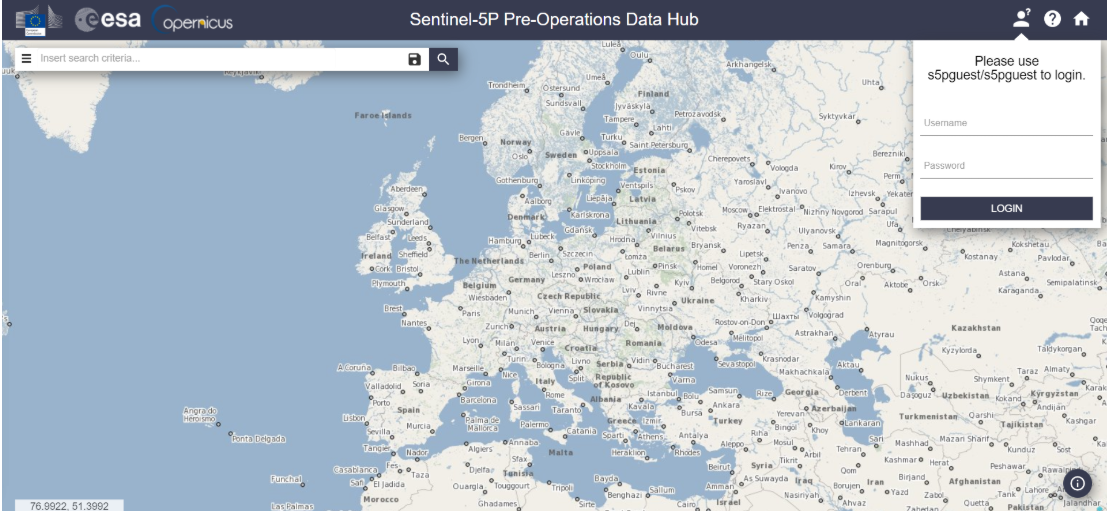

Draw polygon over the area of interest

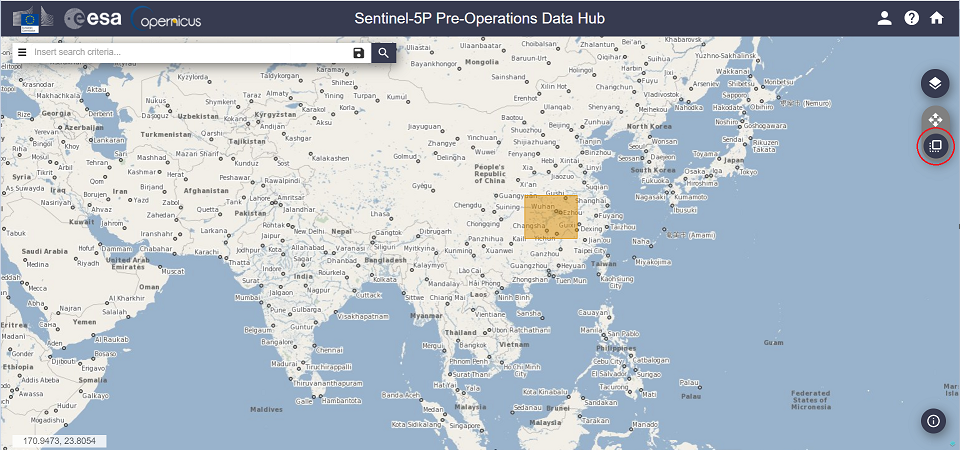

Fill the parameters:

* `Sort By`: The data can be sort by Cloud Coverage, Ingestion Date, Sensing Date and Tile ID

* `Sensing period / Ingestion period`  : Specify the time period

* `Product Type`  : L2__NO2___

* `Processing Level`  : L2

* `Timeliness`:   `Near real time` and `Offline` data is available

* `Absolute Orbit Number`:   Data for a specific orbit can be specified


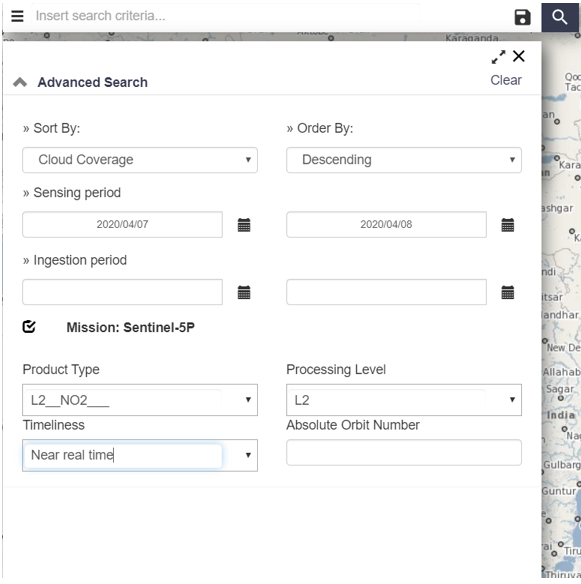

Download data from the product list

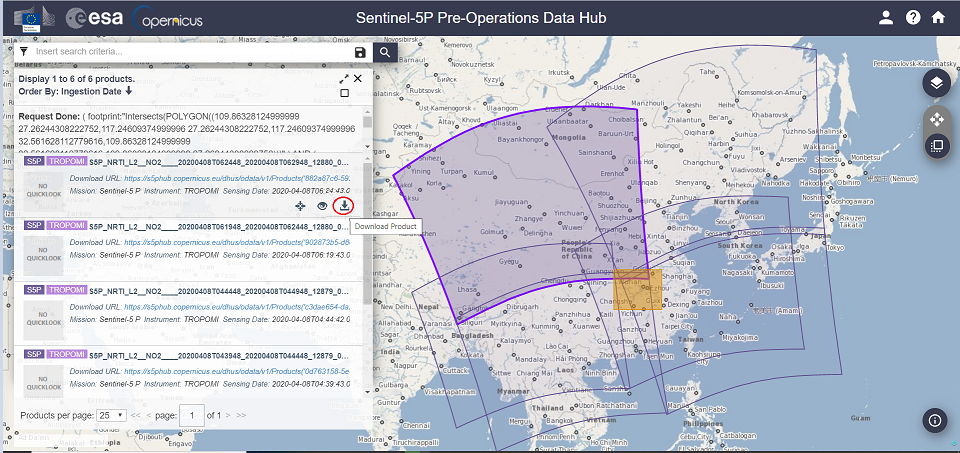

The data was downloaded for 8 days starting from December to April: 12 & 31 December, 2019; 14 & 29 January, 2020; 09 February; 10 & 20 March, 2020, 09 April, 2020.

### Extract data from NetCDF file<a class="anchor" id="6"></a>

The data format of Sentinel-5P is NetCDF. The data has to be converted into TIFF format.
Click on Map -> Click on the drop down of Add Data -> Select Multidimensional Raster Layer.

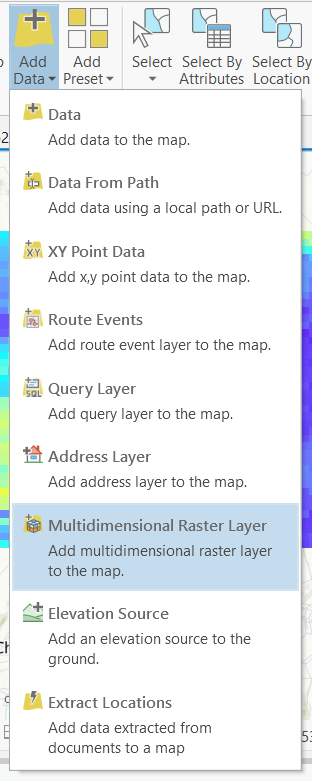

In the Multidemsional Raster Layer tab:
* In `Input File, Mosaic Dataset or Image Service`, select the `.nc` file
* In `Select Variables`, tick `cloud_radiance_fraction_nitrogendioxide_window`, `surface_albedo`, `nitrogen_tropospheric_column`
* In `Output Configuration` select `Multidimensional Raster`

Click Ok

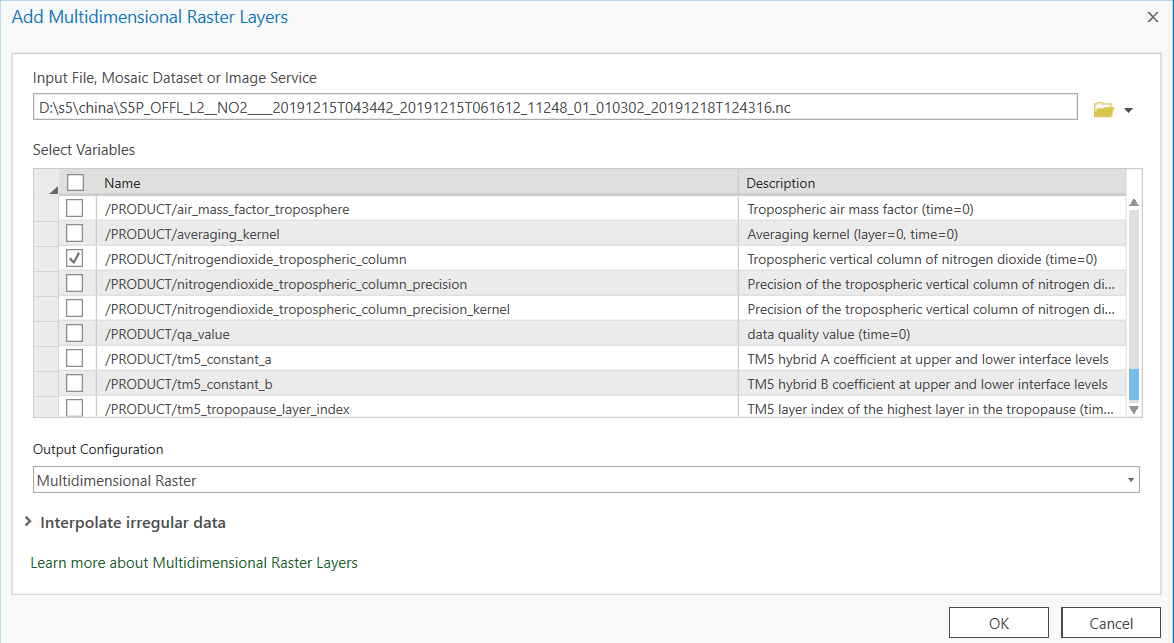

All three layers will be added in the Map.

Next step is to convert the `.nc` to `.tif` format. Right click on the layer in `Content tab`, Click `Data` and then select `Export Raster`.

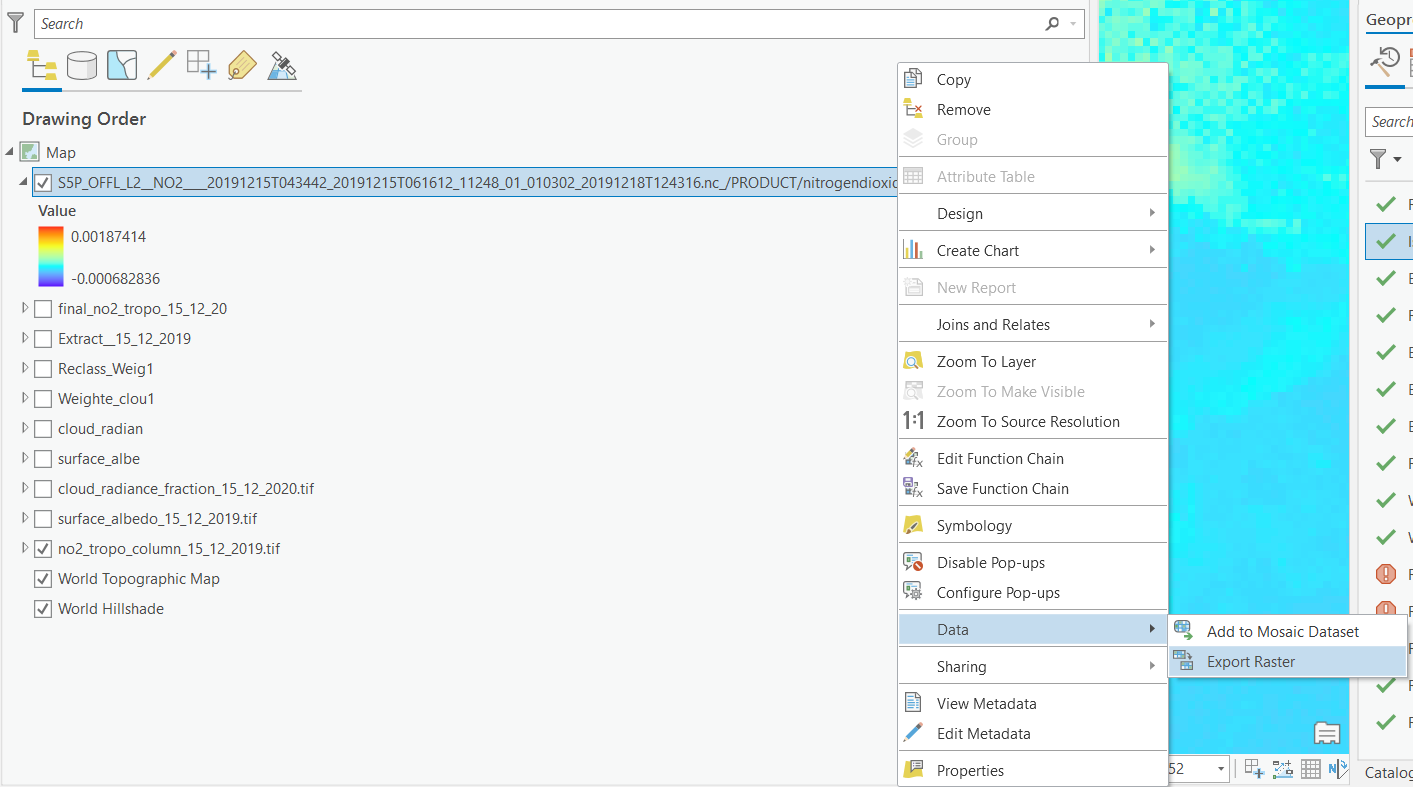

In `Export Raster` tab
* `Output Raster Dataset` = Path for output raster
* `Pixel Type` = 32 Bit float
* `Output Format` = TIFF

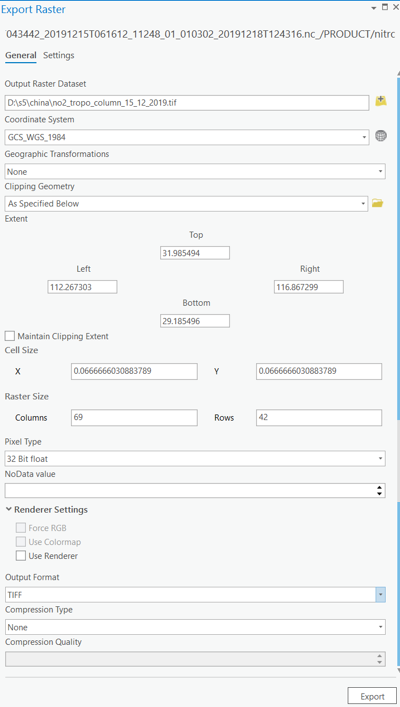

Do the same steps for the other .nc files

### Publish extracted rasters<a class="anchor" id="7"></a>

Detailed steps for publishing the rasters as image service using ArcGIS Pro can refered from [here](https://pro.arcgis.com/en/pro-app/help/sharing/overview/publish-an-image-service.htm)

### Access the published data for analysis<a class="anchor" id="8"></a>

In [6]:
no2_layers = gis.content.search('s5', max_items=100)
no2_layers

[<Item title:"s5cloud_09022020" type:Imagery Layer owner:admin>,
 <Item title:"s5salb_14012020" type:Imagery Layer owner:admin>,
 <Item title:"s5salb_09022020" type:Imagery Layer owner:admin>,
 <Item title:"s5salb_12122019" type:Imagery Layer owner:admin>,
 <Item title:"s5cloud_14012020" type:Imagery Layer owner:admin>,
 <Item title:"s5cloud_12122019" type:Imagery Layer owner:admin>,
 <Item title:"s5no2t_14012020" type:Imagery Layer owner:admin>,
 <Item title:"s5no2t_12122019" type:Imagery Layer owner:admin>,
 <Item title:"s5no2t_31122019" type:Imagery Layer owner:admin>,
 <Item title:"s5cloud_31122019" type:Imagery Layer owner:admin>,
 <Item title:"s5no2t_09022020" type:Imagery Layer owner:admin>,
 <Item title:"s5salb_31122019" type:Imagery Layer owner:admin>,
 <Item title:"s5salb_29012020" type:Imagery Layer owner:admin>,
 <Item title:"s5no2t_29012020" type:Imagery Layer owner:admin>,
 <Item title:"s5cloud_10032020" type:Imagery Layer owner:admin>,
 <Item title:"s5cloud_20032020" typ

In [7]:
from datetime import datetime
layer_mapping={'cloud':'s5cloud', 'no2':'s5no2t', 'albedo':'s5salb'}
timestamps=set([layer.title[-8:] for layer in no2_layers])
timestamps=[t.strftime('%d%m%Y') for t in sorted([datetime.strptime(t,'%d%m%Y') for t in timestamps])]

## Methodology<a class="anchor" id="9"></a>

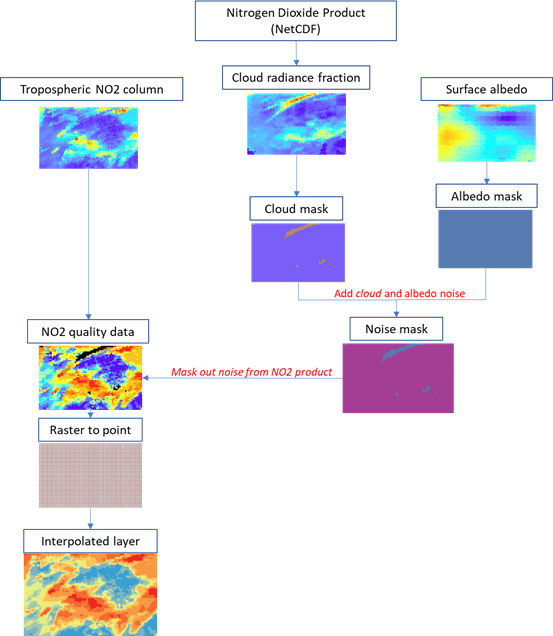

## Preprocessing of the data<a class="anchor" id="10"></a>

### Filter out the noise<a class="anchor" id="11"></a>

Since, weather is a dynamic phenomenon and it affects the quality of data. To remove the noise from the data, clouds and surface albedo were removed. The [Sentinel-5P Level-2 manual](https://sentinel.esa.int/documents/247904/2474726/Sentinel-5P-Level-2-Product-User-Manual-Nitrogen-Dioxide) specifies QA threshold value for both "surface_albedo" and "cloud_radiance_fraction".

#### Create cloud mask<a class="anchor" id="11"></a>

QA threshold for "cloud_radiance_fraction" < 0.5.

In [8]:
def process_cloud_layer(cloud_layer):
    print('Processing cloud layer',end='\r')
    filter_cloud = less_than([cloud_layer, 0.5],
                             extent_type='FirstOf',
                             cellsize_type='FirstOf',
                             astype='F32')
    return filter_cloud

#### Create surface albedo mask<a class="anchor" id="12"></a>

QA threshold for "surface_albedo" < 0.3.

In [9]:
def process_albedo_layer(albedo_layer):
    print('Processing albedo layer',end='\r')
    filter_alb = less_than([albedo_layer, 0.3],
                           extent_type='FirstOf',
                           cellsize_type='FirstOf',
                           astype='F32')
    return filter_alb   

## Extract good quality NO2 pixels<a class="anchor" id="13"></a>

To extract the good quality NO2 pixels, first both cloud and surface albedo masks were added to get the noise mask. The values of "Noise mask" ranges from 1-2.

[threshold](https://pro.arcgis.com/en/pro-app/help/data/imagery/binary-thresholding-function.htm) function was used to convert the range of "Noise mask" from 1-2 to 0-1.

[is_null](https://pro.arcgis.com/en/pro-app/help/data/imagery/is-null-function.htm) function was used to create "False raster" which has 1 value where input value is NoData and 0 where data is present.

[Con](https://pro.arcgis.com/en/pro-app/tool-reference/spatial-analyst/con-.htm) function was used to mask out the noise and get good quality data. 
* "threshold_raster" was taken as `in_conditional_raster` which represents the true or false result of the desired condition.
* "no2_layer" was taken as `in_true_raster_or_constant` whose value will be used as the output cell value if the condition is true.
* "null_raster" was specified as `in_false_raster_or_constant` whose value will be considered as the output cell values if the condition is false.

The output raster of `Con` function only has good quality pixels.

In [10]:
def create_apply_mask(no2_layer, filter_cloud, filter_alb):
    print('Creating mask              ',end='\r')
    binary_r=filter_cloud+filter_alb                    #create mask
    threshold_r = threshold(binary_r,                   #threshold
                            astype='F32') 
    null_r = is_null([threshold_r],                     #null raster
                     cellsize_type='MaxOf', 
                     astype="F32") 
    con_r = con([threshold_r, no2_layer, null_r],       #condition
               extent_type='FirstOf', 
               cellsize_type='FirstOf', 
               astype="F32")
    con_p = con_r.save("cn"+t)
    con_lyr=con_p.layers[0]
    return con_lyr

## Estimating the missing values<a class="anchor" id="14"></a>

### Extract point data<a class="anchor" id="15"></a>

The con output raster was converted to point data using `to_features` function. So, that it can be used to interpolate the missing values. The value of points with 0 will be replaced with "None" using [CalculateField](https://pro.arcgis.com/en/pro-app/tool-reference/data-management/calculate-field.htm) because `interpolate_points` function which will be used to interpolate the missing values does not considers 0 as NoData. The output point feature was used for interpolating the missing values. 

In [11]:
def raster_to_point(con_lyr,t):
    print('Converting raster to point',end='\r')
    #con_url=con_p.url
    point_f = con_lyr.to_features(field='Value',
        output_type='Point',
        simplify=True,
        output_name="point_"+t                       
        )


    point_calc = calculate_fields(input_layer=point_f,
                          field_name="grid_code",
                          data_type='Double',
                          expression="""IIf($feature["grid_code"] == 0, 'None', $feature["grid_code"])""",
                          output_name="c_pt_"+t)
    return point_calc

## Interpolating the missing values<a class="anchor" id="16"></a>

The noise was removed from the "NO2 raster" and it was replaced with NoDATA. The values for NoData pixels were interpolated using [interpolate_points](https://pro.arcgis.com/en/pro-app/tool-reference/feature-analysis/interpolate-points.htm) which is designed to work with data that changes slowly and smoothly over the landscape, like temperature and pollution levels.

In [12]:
def interpolated_missing_values(point_calc,t):
    intp = interpolate_points(point_calc.layers[0],
                              "grid_code", 
                              interpolate_option='5', 
                              classification_type='Manual',
                              num_classes=8,
                              class_breaks=[0.000030,0.000042,0.000053,0.000067,0.000087,0.000125,0.000192,0.0007],
                              output_name="intrp"+t)
    return intp
    print('Interpolated output',end='\r')

All the above mentioned functions were looped together for time series analysis.

In [13]:
for t in timestamps:
    
    print(f'Processing layers for time :{t}\n')
    
    cloud_layer,no2_layer,albedo_layer = layer_mapping.get('cloud'),layer_mapping.get('no2'),layer_mapping.get('albedo')
    
    cloud_layer = gis.content.search(f'{cloud_layer}_{t}')[0].layers[0]
    no2_layer = gis.content.search(f'{no2_layer}_{t}')[0].layers[0]
    albedo_layer = gis.content.search(f'{albedo_layer}_{t}')[0].layers[0]
    
    filter_cloud=process_cloud_layer(cloud_layer=cloud_layer)
    filter_alb=process_albedo_layer(albedo_layer=albedo_layer)
    
    con_lyr=create_apply_mask(no2_layer=no2_layer, filter_cloud=filter_cloud,filter_alb=filter_alb)
    
    point_calc=raster_to_point(con_lyr=con_lyr,t=t)
    intp=interpolated_missing_values(point_calc,t=t)

Processing layers for time :12122019

Processing layers for time :31122019

Processing layers for time :14012020

Processing layers for time :29012020

Processing layers for time :09022020

Processing layers for time :10032020

Processing layers for time :20032020

Processing layers for time :09042020



## Visualise results <a class="anchor" id="17"></a>

### Create map wigets<a class="anchor" id="18"></a>

8 map wigets were created representing the 8 days. In these map widgets, the data will be added in the next section.

In [3]:
# 12 December 2019
m1 = gis.map("China", 4)
m1

MapView(layout=Layout(height='400px', width='100%'))

In [4]:
## 31 December 2019
m2 = gis.map("China", 4)
m2

MapView(layout=Layout(height='400px', width='100%'))

In [5]:
## 14 January 2020
m3 = gis.map("China", 4)
m3

MapView(layout=Layout(height='400px', width='100%'))

In [6]:
## 29 January 2020
m4 = gis.map("China", 4)
m4

MapView(layout=Layout(height='400px', width='100%'))

In [7]:
## 09 February 2020
m5 = gis.map("China", 4)
m5

MapView(layout=Layout(height='400px', width='100%'))

In [8]:
## 10 March 2020
m6 = gis.map("China", 4)
m6

MapView(layout=Layout(height='400px', width='100%'))

In [9]:
## 20 March 2020
m7 = gis.map("China", 4)
m7

MapView(layout=Layout(height='400px', width='100%'))

In [10]:
## 09 April 2020
m8 = gis.map("China", 4)
m8

MapView(layout=Layout(height='400px', width='100%'))

### Synchronize web maps<a class="anchor" id="23"></a>

All the maps were synchronized with each other using [MapView.sync_navigation](https://developers.arcgis.com/python/api-reference/arcgis.widgets.html#arcgis.widgets.MapView.sync_navigation) functionality. It will help in comparing the changes in NO2 concentration with time. Detailed description about advanced map widget options can be refered from [here](https://developers.arcgis.com/python/guide/advanced-map-widget-usage/)

In [11]:
m1.sync_navigation(m2)
m2.sync_navigation(m3)
m3.sync_navigation(m4)
m4.sync_navigation(m5)
m5.sync_navigation(m6)
m6.sync_navigation(m7)
m7.sync_navigation(m8)

### Add dataframe as layer in map<a class="anchor" id="22"></a>

Dataframes of different days were plotted in the web map using `item.spatial.plot` function.

In [12]:
## Create list of web maps
map_list = [m1, m2, m3, m4, m5, m6, m7, m8]

In [13]:
## interpolated polygons
intrp = gis.content.search('intrp')
## create a list for dataframes
df_lst = []
for intp in intrp:
    df_lst.append(intp.layers[0].query(as_df=True))

`item.spatial.plot` function was used to add the dataframes to web maps. The lists of web maps and dataframes which were created in the above cell will be used in this step, so that the function can be run in a loop. Each dataframe was added to seperate web map.

In [15]:
import time
## Add NO2 dataframes to web maps
for df, m in zip(df_lst, map_list):
    time.sleep(2)
    df.spatial.plot(map_widget=m,
                   renderer_type='c',  
                   method='esriClassifyNaturalBreaks',  
                   class_count=8,  
                   col='classes',  
                   cmap='jet',
                   outline_color=[0,0,0,0],
                   alpha=0.7
                   )
    m.zoom_to_layer(df)
    m.legend = True

The layers in web maps are showing the spatio-temporal variations in the tropospheric NO2 concentration. Red pixels in the map represents very high NO2 concentration and the concentration decreases from Red to Blue. Yellow and Green pixels represents high and moderate NO2 concentration. It can be seen, the NO2 concentration is declining with the time (from December to April) which shows the impact of lockdown. In Wuhan from 23 January,2020 lockdown was started and the plots also shows how the concentration is decreasing from 29 January to 09 April. The web maps  of 10 March and 07 April very less pixels are showing high concentration. The web map of 09 April, mostly has Blue pixels which means most of the study ares has very low NO2 concentration but the map has some red pixels as well because the lockdown of Wuhan ended on 07 April. A cluster of high NO2 concentration in Red, Yellow and Green color is visible over the Wuhan city on every date but the cluster is shrinking over the time.

By clicking anywhere on the map the value for tropospheric NO2 for that value will be shown in a tab in `classes`. 

## Conclusion<a class="anchor" id="19"></a>

Wuhan is one of the most populous city of China which is related high economic growth, industries, large number of vehicles, etc. With urbanisation and industrial growth pollution also increases, suggesting high concentration of NO2. To control the spread COVID-19 Epidemic the city was locked down and all the industries, vehicles and other sources of NO2 emission were stopped. Due to which the NO2 levels in the atmosphere also decreases after lockdown over Wuhan. Sentinel-5P NO2 data product was used for studying the spatial variations of NO2 concentration in atmosphere over time. The results of the study suggests that the NO2 concentration over Wuhan was decreased after the COVID-19 lockdown. The same methodology can be used to study the NO2 concentration for different regions with Sentinel-5P NO2 data product using ArcGIS platform.  

## Data Resources<a class="anchor" id="20"></a>

| Data and literature | Source | Link |
| -| - |-|
| Sentinel-5P NO2 Product|          Sentinel-5P Pre-Operations Data Hub | https://s5phub.copernicus.eu/dhus/#/home| 
|User Manual|                       Sentinel-5P Level 2 User Manual        | https://sentinel.esa.int/documents/247904/2474726/Sentinel-5P-Level-2-Product-User-Manual-Nitrogen-Dioxide|
| Research Paper|                   Spatial Variation of NO2 and Its Impact Factors in China: An Application of Sentinel-5P Products           | https://www.researchgate.net/publication/335249253_Spatial_Variation_of_NO2_and_Its_Impact_Factors_in_China_An_Application_of_Sentinel-5P_Products|
| Research Paper|                   Spaceborne Nitrogen Dioxide Observations from the Sentinel-5P TROPOMI over Turkey           |   https://www.mdpi.com/2504-3900/18/1/4/pdf|